In [3]:
import pandas as pd

In [4]:
df_test = pd.read_csv('../dataset/validation-set-rfam-corrected.csv', index_col=0)

In [5]:
df_test

,index,id,seq,label
0,21355,LGCL01000045.1/11910-11982,AATTAAAAAAGCGATGAGGCTCGCTTGAGATGTAATCAAACCGCCG...,Riboswitch
1,11684,ALWZ044445528.1/962-1083,ATCCTAGGTAAGCCCTTTAAACTACTTATCTGATTTATGGGAGACA...,HACA-box
2,14551,LT598460.1/687408-687646,AACTTTGTCCAAAAGTACTCCACCGCAATAGACAGTACGACGGCCG...,HACA-box
3,6725,AYZS02015661.1/13237-13329,TTGCCATGATGATTTCAAATTATTAGGAAAGCATTATGCTAATGCT...,CD-box
4,28222,KB846811.1/2403452-2403262,AATCTGGGAAGAGAGCTTCCTTCAGTCCACTCATGGGGAGTGGTAA...,miRNA
...,...,...,...,...
13641,18742,FCNA01000158.1/16563-16326,GAAAAAGCGTTGAAAAGATGAGTAGTTTTGGATAGACTTATAGAGA...,Leader
13642,13516,AFYH01058929.1/8670-8538,TCCCAAGGTGTTGAGTTCAGTTCAGGGCTGCTTCCCTGTTCTGGTA...,HACA-box
13643,28677,ABEG02003677.1/12241-12145,AAGGGGTGTCAAAGTAGAGGTAGGTGCGAGAAATGACGGGCATCGT...,miRNA
13644,6156,CM002815.1/56721418-56721311,CGTCATGATTTGGGCATTGCATTAACTTATCATTAAAGTATGTTGA...,CD-box


# 1 - split dataset into individual fasta files

In [8]:
def split_fasta(df):
    
    for n,s in enumerate(df['seq']):
        with open('./single-fasta/{}.fasta'.format(n), 'w') as output_file:
            output_file.write('>{}_{} \n'.format(df['index'][n], df['label'][n]))
            output_file.write('{} \n'.format(s))

In [10]:
split_fasta(df_test)

# 2 - run nhmmer for each sequence

### - execute script 'run.sh'

In [54]:
# for i in {0..13645}
# do
# 	nhmmer ./single-fasta/$i.fasta ../training-set-corrected.fasta > ./single-output/$i.out
# done


In [55]:
# command: time run.sh
# real	111m3,580s
# user	395m21,046s
# sys	6m9,383s

# 3 - process and merge results

In [6]:
def process_merge(n_files, out_name, df_test):

    df = pd.DataFrame()

    query = []
    e_value = []
    score = []
    bias = []
    sequence = []
    label = []

    for x in range(n_files):

        with open('./single-output/{}.out'.format(x), 'r') as file:
            lines = file.readlines()
            for n,line in enumerate(lines[10:]):
        
                if n == 0:
                    query.append(line.strip().split()[1])
                elif n==4:
                    line_list = line.strip().split()
            
                    if len(line_list) == 0:
                        e_value.append(0)
                        score.append(0)
                        bias.append(0)
                        sequence.append('None')
                        label.append('None')
                    
                    elif 'inclusion' in line_list:
                        e_value.append(0)
                        score.append(0)
                        bias.append(0)
                        sequence.append('None')
                        label.append('None') 
                
                    else:
                        e_value.append(line.strip().split()[0])
                        score.append(line.strip().split()[1])
                        bias.append(line.strip().split()[2])
                        sequence.append(line.strip().split()[3].split('_')[0])
                        label.append(line.strip().split()[3].split('_')[1])
            
    df['dataset_id'] = query
    df['e_value'] = e_value
    df['score'] = score
    df['bias'] = bias
    df['match_id'] = sequence
    df['match_label'] = label
    
    df['query_label'] = df_test['label']
    df['query_id'] = df_test['index']

    df.to_csv('{}.csv'.format(out_name))
    
    return df

In [ ]:
df_out = process_merge(13646, 'results', df_test)

In [ ]:
df_out.to_csv('./results.csv')

In [8]:
df_out = pd.read_csv('./results.csv', index_col=0)

In [9]:
df_out

,dataset_id,e_value,score,bias,match_id,match_label,query_label,query_id
0,0,0.000000e+00,0.0,0.0,None,None,Riboswitch,21355
1,1,1.200000e-09,40.0,5.7,13858,HACA-box,HACA-box,11684
2,2,3.800000e-32,111.9,2.7,14920,HACA-box,HACA-box,14551
3,3,1.100000e-04,24.3,9.3,8707,CD-box,CD-box,6725
4,4,4.400000e-29,102.2,3.5,27411,miRNA,miRNA,28222
...,...,...,...,...,...,...,...,...
13641,13641,1.400000e-13,52.5,11.4,15502,Leader,Leader,18742
13642,13642,1.400000e-10,43.1,1.8,14038,HACA-box,HACA-box,13516
13643,13643,2.600000e-12,47.9,0.0,27582,miRNA,miRNA,28677
13644,13644,1.200000e-11,46.3,6.6,6058,CD-box,CD-box,6156


In [10]:
from collections import Counter

print('{} sequences without hits.'.format(list(df_out['match_label']).count('None')))

no_hits = []
for n,s in enumerate(df_out['match_label']):
    if s == 'None':
        no_hits.append(df_out['query_label'][n])
        
print('true labels of no hit sequences:')
Counter(no_hits)

1121 sequences without hits.
true labels of no hit sequences:


Counter({'Riboswitch': 126,
         'CD-box': 283,
         'miRNA': 237,
         'HACA-box': 89,
         'Ribozyme': 71,
         'Leader': 42,
         'Intron-gp-II': 31,
         'tRNA': 237,
         'Y-RNA-like': 2,
         '5.8S-rRNA': 1,
         'Y-RNA': 2})

In [11]:
y_true = df_out['query_label'].values
y_pred = df_out['match_label'].values

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   5.8S-rRNA       1.00      0.99      1.00       126
     5S-rRNA       1.00      1.00      1.00      1500
      CD-box       1.00      0.81      0.90      1504
    HACA-box       1.00      0.94      0.97      1485
 Intron-gp-I       0.99      1.00      0.99       390
Intron-gp-II       1.00      0.97      0.98      1089
      Leader       1.00      0.97      0.98      1514
        None       0.00      0.00      0.00         0
  Riboswitch       1.00      0.91      0.95      1483
    Ribozyme       1.00      0.95      0.97      1408
       Y-RNA       0.98      0.98      0.98       107
  Y-RNA-like       0.97      0.95      0.96        41
       miRNA       1.00      0.83      0.91      1466
        tRNA       1.00      0.84      0.91      1533

    accuracy                           0.92     13646
   macro avg       0.92      0.87      0.89     13646
weighted avg       1.00      0.92      0.95     13646



In [16]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

print('Alignment-based classification')
print('accuracy: {}'.format(balanced_accuracy_score(y_true, y_pred)))
print('precision: {}'.format(precision_score(y_true, y_pred, average='weighted')))
print('recall: {}'.format(recall_score(y_true, y_pred, average='weighted')))
print('f1_score: {}'.format(f1_score(y_true, y_pred, average='weighted')))
print('MCC: {}'.format(matthews_corrcoef(y_true, y_pred)))

Alignment-based classification
accuracy: 0.9346223732640188
precision: 0.9979000995271606
recall: 0.9158727832331819
f1_score: 0.9538365635434455
MCC: 0.9112284227838714


In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
							 confusion_matrix,
							 roc_auc_score)

label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I', 
              'Intron-gp-II', 'Leader', 'None','Riboswitch', 'Ribozyme', 'Y-RNA',
              'Y-RNA-like', 'miRNA ', 'tRNA']


def plot_cm(labels, argmax_prediction, normalize, fmt, title):
    cm = confusion_matrix(labels, argmax_prediction, normalize=normalize)
    fig = plt.figure(figsize=(10, 8), dpi=150)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, xticklabels=label_list, yticklabels=label_list,
                cmap='Reds', fmt=fmt, square=True, annot=True)
    
    plt.title(title, fontsize=20)
    plt.ylabel("True label", fontsize=19)
    plt.xlabel("Predicted label", fontsize=19)
    #ax = fig.add_subplot(111)
    #plt.set_xticklabels(label_list)
    #plt.set_yticklabels(label_list)
    plt.yticks(rotation='horizontal', fontsize=18)
    plt.xticks(rotation='vertical', fontsize=18)
    plt.show()

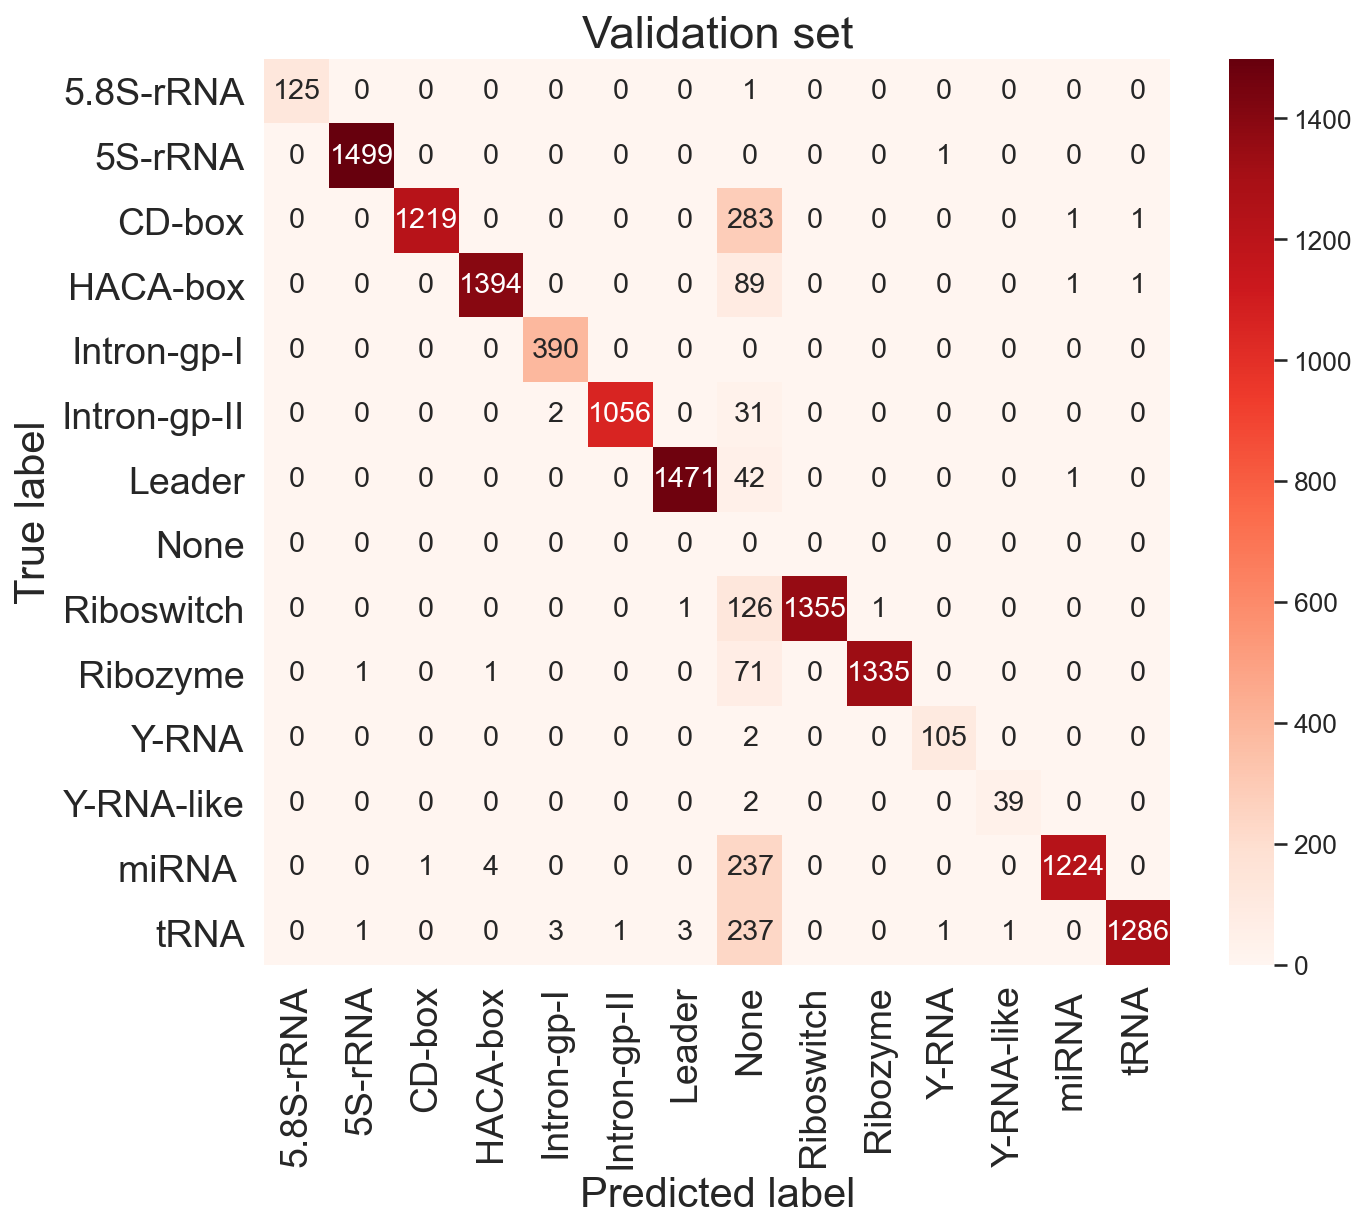

In [18]:
title = 'Validation set'
plot_cm(y_true, y_pred, None,'.0f', title)

In [17]:
none_match = []
for n,s in enumerate(df_out['match_label']):
    if s == 'None':
        none_match.append(int(df_out['query_id'][n]))

In [18]:
df_none = df_test.loc[df_test['index'].isin(none_match)]
df_none = df_none.reset_index(drop=True)

In [19]:
len(none_match)

1121

In [20]:
df_none

,index,id,seq,label
0,21355,LGCL01000045.1/11910-11982,AATTAAAAAAGCGATGAGGCTCGCTTGAGATGTAATCAAACCGCCG...,Riboswitch
1,8946,AYCK01016167.1/24037-24113,CTGCAGTGATGAATCTTTTGAACTCTCTCTTACCGAATCAACCTTT...,CD-box
2,6099,GG745361.1/174658-174570,TTGGATGGATGTGAAAACGGACTTTCAACTCTCCTGAATCCAACAA...,CD-box
3,6245,LVLJ01003561.1/368393-368458,AAGCGTATGAAGAATTTATGGATTCCCCTTCACTTAATTATAAGTG...,CD-box
4,20690,LAQT01000037.1/52502-52579,CTTCCGGGGAGCGCTGCAAGTTGTGGTTGTGATCCAGCCATGCCCC...,Riboswitch
...,...,...,...,...
1116,5729,CM007648.1/223880663-223880582,TCTAGACTTTGATGATTTGCAAATACCATTTGCCTACATCGTTTTA...,CD-box
1117,22761,LOES01000122.1/6105-6044,ATAACAACTGGCGAAGGAGTTCGCCATTAATCGTCCTAGTGACTAA...,Riboswitch
1118,26454,JXUM01048293.1/27301-27210,TTATGCGCGGTCCCACGTATGCCACTACATTTTTATATATATAGAT...,miRNA
1119,9758,KV778178.1/20503-20434,TTGGCATGATGAGGAAATTAATACATTGTGCCTGATCCGCTGGATG...,CD-box


# Check if NCYPred can classify these sequences

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

In [22]:
def remove(df):
	for i in range(len(df.seq)):
		for j in ['N', 'Y', 'K', 'W', 'R', 'H', 'M', 'S', 'D', 'V', 'B']:
			if j in df.seq[i]:
				df = df.drop(index=i)
				break

	df = df.reset_index(drop=True)
	return df

def seq_to_3mer(seq_list):
	print('Processing {} sequences'.format(len(seq_list)))
	
	main_list = []
	
	for _, i in enumerate(seq_list):
		# print('type(i): ', type(i))
		# print('type([i]): ', type([i]))
		# print('type(list(i)): ', type(list(i)))
		seq = list(i)
		seq_kmer = []

		for j, _ in enumerate(seq):
			if j < len(seq) - 2:
				seq_kmer.append(seq[j] + seq[j+1] + seq[j+2])
			else:
				continue

		main_list.append(seq_kmer)

	return main_list 

def token_pad(sentences, max_len, prefix):
	print('Zero-padding sequences to {} and tokenizing'.format(max_len))

	with open('./tokenizer.pickle', 'rb') as handle:
		tokenizer = pickle.load(handle)

	tokens = tokenizer.texts_to_sequences(sentences)
	all_pad = pad_sequences(tokens, max_len, padding=prefix)

	return all_pad

def argmax_to_label(predictions):
	label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I',
		'Intron-gp-II', 'Leader', 'Riboswitch', 'Ribozyme', 'Y-RNA',
		'Y-RNA-like', 'miRNA', 'tRNA']

	argmax_pred = np.argmax(predictions, axis=1)
	argmax_values = range(13)
	pred_labels = []

	for p in argmax_pred:
		for n, l in zip(argmax_values, label_list):
			if p == n:
				pred_labels.append(l)

	return np.array(pred_labels, dtype='object'), label_list

In [23]:
# Remover caracteres proibidos
df_none = remove(df_none)

# Gerar k-mers
X_3mer_test = seq_to_3mer(df_none['seq'])

Processing 1121 sequences


In [24]:
# Tokenization and zero-padding
X_test = token_pad(X_3mer_test, 498, 'post')

Zero-padding sequences to 498 and tokenizing


In [25]:
y_test = np.ravel(df_none['label'])

In [26]:
print(X_test.shape, y_test.shape)

(1121, 498) (1121,)


In [27]:
model = keras.models.load_model('./NCYPred_model/')

In [28]:
y_pred_prob = model.predict(X_test)
y_pred, label_list = argmax_to_label(y_pred_prob)

In [29]:
y_test

array(['Riboswitch', 'CD-box', 'CD-box', ..., 'miRNA', 'CD-box', 'tRNA'],
      dtype=object)

In [30]:
y_pred

array(['Riboswitch', 'CD-box', 'CD-box', ..., 'miRNA', 'CD-box', 'tRNA'],
      dtype=object)

In [31]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

print('sequences without significant alignments (1121 sequences)')
print('accuracy: {}'.format(balanced_accuracy_score(y_test, y_pred)))
print('precision: {}'.format(precision_score(y_test, y_pred, average='weighted')))
print('recall: {}'.format(recall_score(y_test, y_pred, average='weighted')))
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('MCC: {}'.format(matthews_corrcoef(y_test, y_pred)))

sequences without significant alignments (1121 sequences)
accuracy: 0.6110224147632478
precision: 0.7869321313824025
recall: 0.7867975022301517
f1_score: 0.7840850332273528
MCC: 0.7399586145173345


C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   5.8S-rRNA       1.00      1.00      1.00         1
     5S-rRNA       0.00      0.00      0.00         0
      CD-box       0.84      0.93      0.88       283
    HACA-box       0.65      0.53      0.58        89
 Intron-gp-I       0.00      0.00      0.00         0
Intron-gp-II       0.63      0.61      0.62        31
      Leader       0.69      0.64      0.67        42
  Riboswitch       0.68      0.79      0.73       126
    Ribozyme       0.84      0.61      0.70        71
       Y-RNA       0.00      0.00      0.00         2
  Y-RNA-like       0.00      0.00      0.00         2
       miRNA       0.71      0.69      0.70       237
        tRNA       0.94      0.93      0.93       237

    accuracy                           0.79      1121
   macro avg       0.54      0.52      0.52      1121
weighted avg       0.79      0.79      0.78      1121



C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\Anaconda3\envs\novo\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
count = 0
for n,s in zip(y_test, y_pred):
    if n == s:
        continue
    else:
        count+=1

print('total: 1121 sequencias')
print('acertos: {}'.format(1121-count))
print('erros: {}'.format(count))

total: 1121 sequencias
acertos: 882
erros: 239


In [34]:
df_out

,dataset_id,e_value,score,bias,match_id,match_label,query_label,query_id
0,0,0.000000e+00,0.0,0.0,None,None,Riboswitch,21355
1,1,1.200000e-09,40.0,5.7,13858,HACA-box,HACA-box,11684
2,2,3.800000e-32,111.9,2.7,14920,HACA-box,HACA-box,14551
3,3,1.100000e-04,24.3,9.3,8707,CD-box,CD-box,6725
4,4,4.400000e-29,102.2,3.5,27411,miRNA,miRNA,28222
...,...,...,...,...,...,...,...,...
13641,13641,1.400000e-13,52.5,11.4,15502,Leader,Leader,18742
13642,13642,1.400000e-10,43.1,1.8,14038,HACA-box,HACA-box,13516
13643,13643,2.600000e-12,47.9,0.0,27582,miRNA,miRNA,28677
13644,13644,1.200000e-11,46.3,6.6,6058,CD-box,CD-box,6156


In [35]:
list(df_out['match_label']).count('None')

1121

In [36]:
len(set(list(df_test.index)))

13646

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
							 confusion_matrix,
							 roc_auc_score)

label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I', 
              'Intron-gp-II', 'Leader', 'Riboswitch', 'Ribozyme', 'Y-RNA',
              'Y-RNA-like', 'miRNA ', 'tRNA']


def plot_cm(labels, argmax_prediction, normalize, fmt, title):
    cm = confusion_matrix(labels, argmax_prediction, normalize=normalize)
    fig = plt.figure(figsize=(10, 8), dpi=150)
    sns.set(font_scale=1.3)
    sns.heatmap(cm, xticklabels=label_list, yticklabels=label_list,
                cmap='Reds', fmt=fmt, square=True, annot=True)
    
    plt.title(title, fontsize=20)
    plt.ylabel("True label", fontsize=19)
    plt.xlabel("Predicted label", fontsize=19)
    #ax = fig.add_subplot(111)
    #plt.set_xticklabels(label_list)
    #plt.set_yticklabels(label_list)
    plt.yticks(rotation='horizontal', fontsize=18)
    plt.xticks(rotation='vertical', fontsize=18)
    plt.show()

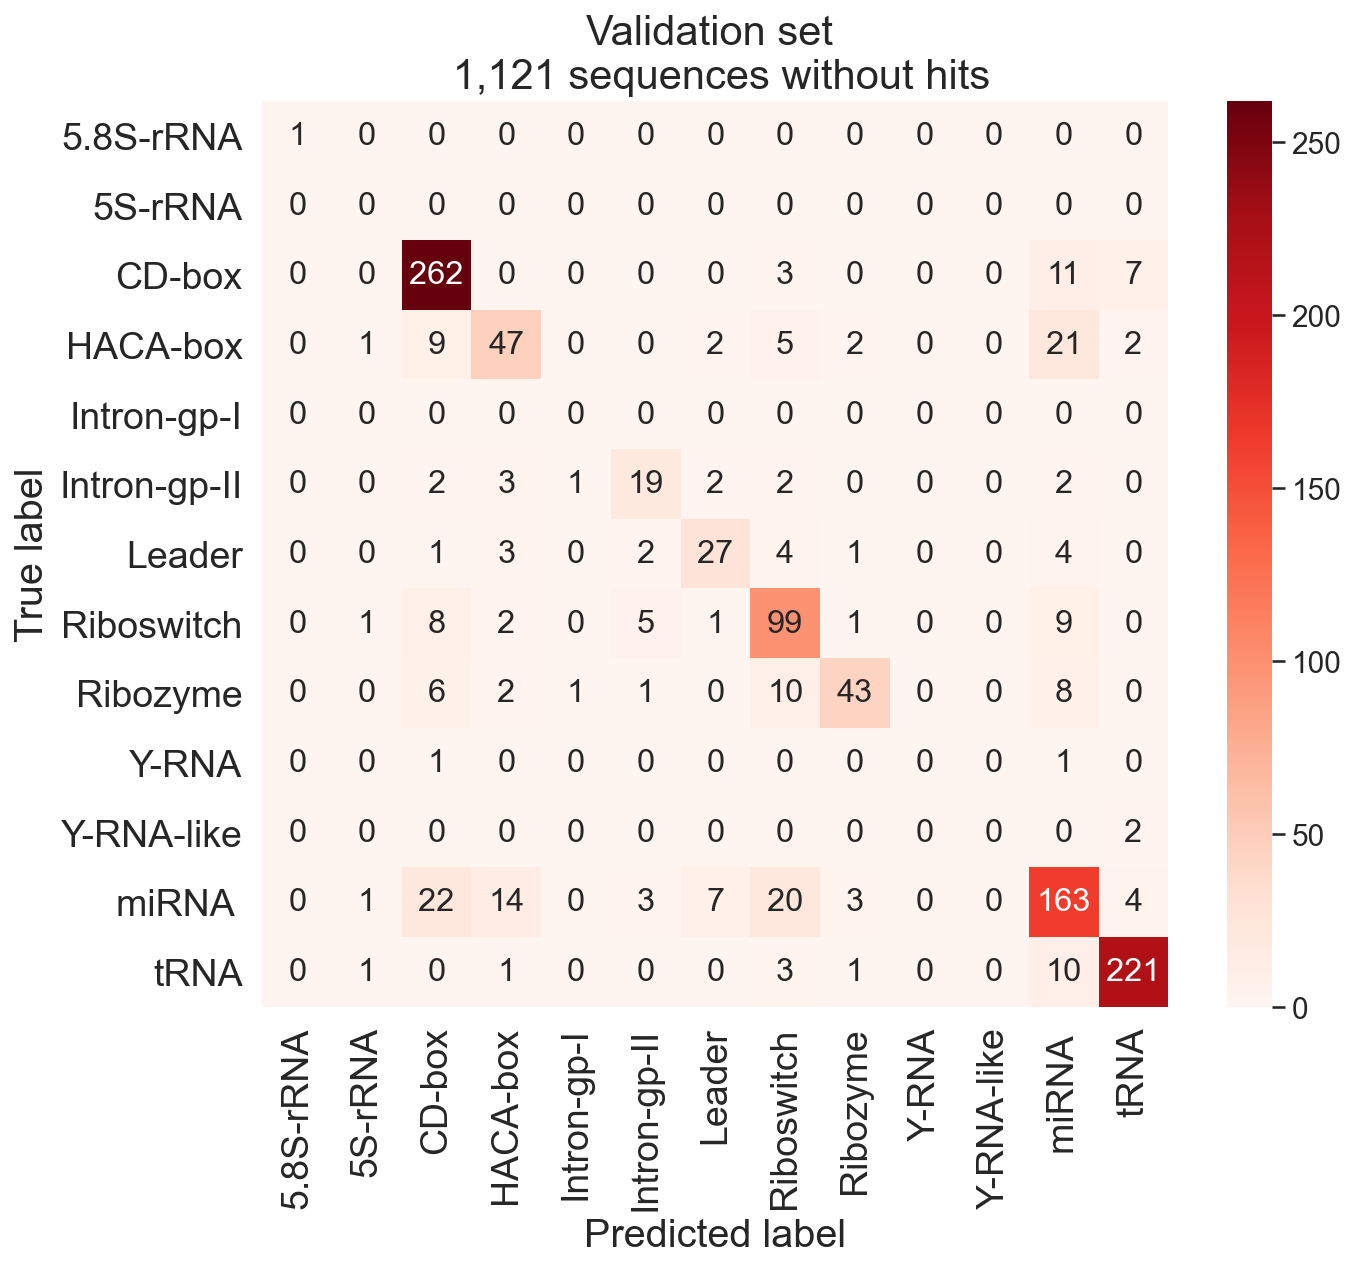

In [40]:
plot_cm(y_test, y_pred, None,'.0f', 'Validation set \n 1,121 sequences without hits')